In [1]:
import logging
import threading
import pandas as pd  
import math
import dill
import numpy as np  
import matplotlib.pyplot as plt
import pydot
import seaborn as seabornInstance
import networkx
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import anomaly
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator, ui, base, bif
from iotfunctions.base import BaseTransformer
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.enginelog import EngineLogging
from iotfunctions import pipeline as pp
from iotfunctions.stages import DataWriterSqlAlchemy, DataWriterFile
from iotfunctions.pipeline import JobController, DataAggregator

import datetime as dt
from scipy.linalg import norm
import scipy as sp
from scipy import signal
from scipy import linalg
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.xgbod import XGBOD

import pmdarima as pm
import inverse_covariance as icov # from package skggm
from inverse_covariance import QuicGraphLasso

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from skimage import util as skiutil # for nifty windowing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1593: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'
Using TensorFlow backend.
/home/markus/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/markus/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing 

In [2]:

# copied from https://github.com/y-bar/ml-based-anomaly-detection
#   remove the boring part from an image resp. time series

def series_filter(values, kernel_size=3):
    """
    Filter a time series. Practically, calculated mean value inside kernel size.
    As math formula, see https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html.
    :param values:
    :param kernel_size:
    :return: The list of filtered average
    """
    filter_values = np.cumsum(values, dtype=float)

    filter_values[kernel_size:] = filter_values[kernel_size:] - filter_values[:-kernel_size]
    filter_values[kernel_size:] = filter_values[kernel_size:] / kernel_size

    for i in range(1, kernel_size):
        filter_values[i] /= i + 1

    return filter_values


def extrapolate_next(values):
    """
    Extrapolates the next value by sum up the slope of the last value with previous values.
    :param values: a list or numpy array of time-series
    :return: the next value of time-series
    """

    last_value = values[-1]
    slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
    slope[0] = 0
    next_values = last_value + np.cumsum(slope)

    return next_values


def marge_series(values, extend_num=5, forward=5):

    next_value = extrapolate_next(values)[forward]
    extension = [next_value] * extend_num

    if isinstance(values, list):
        marge_values = values + extension
    else:
        marge_values = np.append(values, extension)
    return marge_values



class Saliency(object):
    def __init__(self, amp_window_size, series_window_size, score_window_size):
        self.amp_window_size = amp_window_size
        self.series_window_size = series_window_size
        self.score_window_size = score_window_size

    def transform_silency_map(self, values):
        """
        Transform a time-series into spectral residual, which is method in computer vision.
        For example, See https://github.com/uoip/SpectralResidualSaliency.
        :param values: a list or numpy array of float values.
        :return: silency map and spectral residual
        """

        freq = np.fft.fft(values)
        mag = np.sqrt(freq.real ** 2 + freq.imag ** 2)
        spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))

        freq.real = freq.real * spectral_residual / mag
        freq.imag = freq.imag * spectral_residual / mag

        silency_map = np.fft.ifft(freq)
        return silency_map

    def transform_spectral_residual(self, values):
        silency_map = self.transform_silency_map(values)
        spectral_residual = np.sqrt(silency_map.real ** 2 + silency_map.imag ** 2)
        return spectral_residual


In [3]:
# Get stuff in
df_input = pd.read_csv('./Issue-603-Temperature.csv',
                  parse_dates=['timestamp'])

# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')

df_input.head(3)

,deviceid,TEMPERATURE,timestamp
0,A101,70.522660,2019-11-24 15:43:00
1,A101,71.719810,2019-11-24 15:48:00
2,A101,72.840277,2019-11-24 15:53:00


In [4]:
# start with a single sensor
df_temp = df_input[(df_input.deviceid == 'A101')][['timestamp','TEMPERATURE']]

time_raw = df_temp['timestamp'].values
#temp_raw = df_temp['TEMPERATURE'].values
# turn timestamp into the index
df_temp = df_temp.set_index('timestamp')

#time_raw = df_temp['EVT_TIMESTAMP'].values
temp_raw = df_temp['TEMPERATURE'].values

# fill out the time gaps by backward filling - 2nd order splines are overkill I guess
def custom_resampler(array_like):
    if (array_like.values.size > 0):
        return array_like.values[0]
    return np.nan

upsampledna = df_temp.resample('5min').apply(custom_resampler)
upsampledna['RAW_TEMPERATURE'] = upsampledna['TEMPERATURE']
upsampled = df_temp.resample('5min').bfill()

df_temp = upsampled.interpolate(method='spline',order=2)
temp_sauber = df_temp['TEMPERATURE'].values

# double the flatline size (from 4 to 8 to 12 datapoints)
temp_flatline = np.insert(temp_sauber, 130, [32.99295068, 32.99295068, 32.99295068, 32.99295068])
temp_flatterline = np.insert(temp_flatline, 130, [32.99295068, 32.99295068, 32.99295068, 32.99295068])

dtemp_sauber = np.gradient(temp_sauber)

temp_sauber[130]

32.99295068

Text(0, 0.5, 'Temperature')

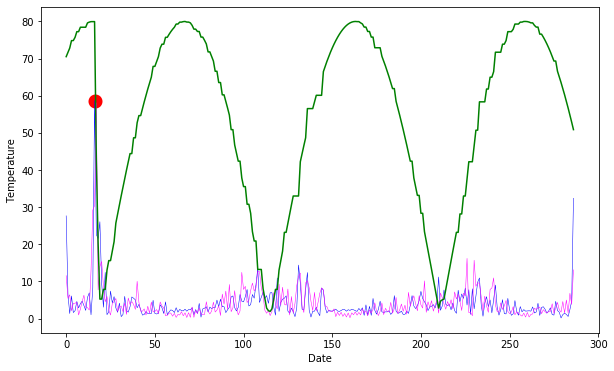

In [5]:
saliency = Saliency(12, 0, 0)
temp_sal = saliency.transform_spectral_residual(temp_sauber)
dtemp_sal = saliency.transform_spectral_residual(dtemp_sauber)

temp_sal *= 80
temp_sal_high = temp_sal.copy()
temp_sal_high[temp_sal_high < 40] = np.nan
x_axis = np.arange(0,temp_sal.size,1)

dtemp_sal *= 80

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(temp_sal, lw=0.5, color='blue')
ax.scatter(x_axis, temp_sal_high, lw=8, color='red')

#ax.plot(dtemp_sauber, lw=1.5, color='magenta')

ax.plot(dtemp_sal, lw=0.5, color='fuchsia')

ax.plot(temp_sauber, lw=1.5, color='green')
#ax.set_ylim(20, 120)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')

In [162]:
rate = 1
MS = 12


freqsTS, timesTS, SxTS = signal.spectrogram(temp_sauber, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - 1,
                                      detrend=False, scaling='spectrum')
freqsTS[freqsTS * MS < 2] = 0

freqsTSf, timesTSf, SxTSf = signal.spectrogram(temp_flatline, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - 1,
                                      detrend=False, scaling='spectrum')
freqsTSf[freqsTSf * MS < 2] = 0

freqsTSff, timesTSff, SxTSff = signal.spectrogram(temp_flatterline, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - 1,
                                      detrend=False, scaling='spectrum')
freqsTSff[freqsTSff * MS < 2] = 0

Mshort = 8
freqsTSfs, timesTSfs, SxTSfs = signal.spectrogram(temp_flatline, fs=rate, window='hanning',
                                      nperseg=Mshort, noverlap=Mshort - 1,
                                      detrend=False, scaling='spectrum')
freqsTSfs[freqsTSfs * Mshort < 2] = 0

Minsanelyshort = 6
freqsTSfis, timesTSfis, SxTSfis = signal.spectrogram(temp_flatline, fs=rate, window='hanning',
                                      nperseg=Minsanelyshort, noverlap=Minsanelyshort - 1,
                                      detrend=False, scaling='spectrum')
freqsTSfis[freqsTSfis * Minsanelyshort < 2] = 0

freqsTSfss, timesTSfss, SxTSfss = signal.spectrogram(temp_sauber, fs=rate, window='hanning',
                                      nperseg=Minsanelyshort, noverlap=Minsanelyshort - 1,
                                      detrend=False, scaling='spectrum')
freqsTSfss[freqsTSfss * Minsanelyshort < 2] = 0

SxTSfs[SxTSfs == 0] = 0.0001
SxTSfis[SxTSfis == 0] = 0.0001


freqsTSfss


array([0.        , 0.        , 0.33333333, 0.5       ])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


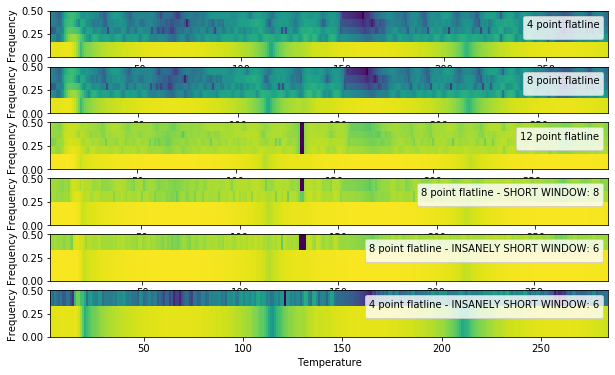

In [163]:
f, ax = plt.subplots(6,1,figsize=(10,6))
ax[0].pcolormesh(timesTS, freqsTS, 10 * np.log10(SxTS)) #, cmap='coolwarm')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Temperature')
ax[0].legend(title='4 point flatline')

ax[1].pcolormesh(timesTSf, freqsTSf, 10 * np.log10(SxTSf)) #, cmap='coolwarm')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Temperature')
ax[1].legend(title='8 point flatline')

ax[2].pcolormesh(timesTSff, freqsTSff, 10 * np.log10(SxTSff)) #, cmap='coolwarm')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Temperature')
ax[2].legend(title='12 point flatline')

ax[3].pcolormesh(timesTSfs, freqsTSfs, 10 * np.log10(SxTSfs)) #, cmap='coolwarm')
ax[3].set_ylabel('Frequency')
ax[3].set_xlabel('Temperature')
ax[3].legend(title='8 point flatline - SHORT WINDOW: ' + str(Mshort))

ax[4].pcolormesh(timesTSfis, freqsTSfis, 10 * np.log10(SxTSfis)) #, cmap='coolwarm')
ax[4].set_ylabel('Frequency')
ax[4].set_xlabel('Temperature')
ax[4].legend(title='8 point flatline - INSANELY SHORT WINDOW: ' + str(Minsanelyshort))

ax[5].pcolormesh(timesTSfss, freqsTSfss, 10 * np.log10(SxTSfss)) #, cmap='coolwarm')
ax[5].set_ylabel('Frequency')
ax[5].set_xlabel('Temperature')
ax[5].legend(title='4 point flatline - INSANELY SHORT WINDOW: ' + str(Minsanelyshort))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


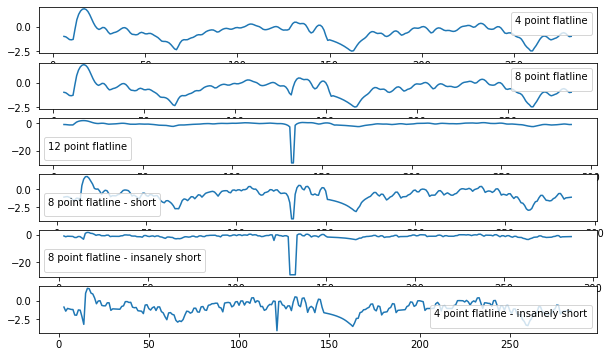

In [167]:
# Signal energy plots
ETS = np.log10(np.dot(SxTS.T, freqsTS))
ETSf = np.log10(np.dot(SxTSf.T, freqsTSf))
ETSff = np.log10(np.dot(SxTSff.T, freqsTSff))
ETSfs = np.log10(np.dot(SxTSfs.T, freqsTSfs))
ETSfis = np.log10(np.dot(SxTSfis.T, freqsTSfis))
ETSfss = np.log10(np.dot(SxTSfss.T, freqsTSfss))

f, ax = plt.subplots(6,1,figsize=(10,6))
ax[0].plot(timesTS, ETS) #, cmap='coolwarm')
ax[0].legend(title='4 point flatline')

ax[1].plot(timesTSf, ETSf) #, cmap='coolwarm')
ax[1].legend(title='8 point flatline')

ax[2].plot(timesTSff, ETSff) #, cmap='coolwarm')
ax[2].legend(title='12 point flatline')

ax[3].plot(timesTSfs, ETSfs) #, cmap='coolwarm')
ax[3].legend(title='8 point flatline - short')

ax[4].plot(timesTSfis, ETSfis) #, cmap='coolwarm')
ax[4].legend(title='8 point flatline - insanely short')

ax[5].plot(timesTSfss, ETSfss) #, cmap='coolwarm')
ax[5].legend(title='4 point flatline - insanely short')


In [116]:
# run-length encoding - see
# https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                  # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(i, z, p, ia[i])



# cut is in slices and try to predict the last value
winsize = 12
slices = skiutil.view_as_windows(temp_sauber, window_shape=(winsize,))

Xl = []
# for prediction 
yl = []
# for anomaly classification
yyl = []
for slice in slices:
    Xl.append(slice[0:winsize-1])
    yl.append(slice[winsize-1:winsize])

    if rle(slice)[0].size < 7:
        print ('yes')
        yyl.append(1)
    else:
        yyl.append(0)
X = np.array(Xl)
y = np.array(yl)
yy = np.array(yyl)
y = np.reshape(y,(y.shape[0],))
yy = np.reshape(yy,(yy.shape[0],))

xshape = X.shape
n_steps= xshape[0]



yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [117]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
Xinput = X.reshape((X.shape[0], X.shape[1], n_features))
Xinput.shape
n_steps = Xinput.shape[1]

In [118]:
yy.dtype

dtype('int64')

In [203]:
# see
# https://jaai.de/convolutional-neural-networks-cnn-aufbau-funktion-und-anwendungsgebiete-1691/
#
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Flatten, Input, Dropout, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils import model_to_dot

opt = optimizers.Adam(0.001)

def get_model():
    inp = Input(shape=(11, 1))
    
    # 2x2 convolution
    img1 = Convolution1D(filters=64, kernel_size=2, activation='relu')(inp)
                #input_shape=(11,1))) # each input vector is 11 elements long and we look for a single feature
    
    # get the largest of the 4 matrices
    img2 = MaxPooling1D(pool_size=2)(img1)
    
    # flatten to an array
    img3 = Flatten()(img2)
    #img3 = GlobalMaxPooling1D()(img2)
    
    
    dense1 = Dense(50, activation='relu')(img3)
    
    #dense2 = Dense(1, activation=activations.softmax)(dense1)

    dense2 = Dense(1, activation=activations.relu)(dense1)
    
    model = models.Model(inputs=inp, outputs=dense2)
    
    # prediction
    model.compile(optimizer='adam', loss='mse')
    # anomaly classification
    #model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    
    model.summary()
    return model

In [107]:
model = get_model()

#plot_model(model, to_file='model.png')
iv1_dot = model_to_dot(model, show_shapes=False, show_layer_names=True) #, rankdir='LR')
iv1_dot.set_size('10x10')

#SVG(iv1_dot.create(prog=['dot'], format='svg'))
#plt.show()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 11, 1)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 10, 64)            192       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                16050     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_______________________________________________________

In [12]:
# fit model
# this model parameter for prediction
model.fit(Xinput, y, epochs=200, validation_split=0.15, batch_size=8, verbose=1)

# this model for categorization
#model.fit(Xinput, yy, epochs=200, validation_split=0.15, batch_size=8, verbose=2)



Train on 234 samples, validate on 42 samples
Epoch 1/200
 - 0s - loss: 369.0406 - val_loss: 52.8901
Epoch 2/200
 - 0s - loss: 136.1396 - val_loss: 12.8566
Epoch 3/200
 - 0s - loss: 89.4138 - val_loss: 22.2993
Epoch 4/200
 - 0s - loss: 61.7937 - val_loss: 1.4728
Epoch 5/200
 - 0s - loss: 56.0869 - val_loss: 20.3468
Epoch 6/200
 - 0s - loss: 41.6752 - val_loss: 2.8606
Epoch 7/200
 - 0s - loss: 36.8396 - val_loss: 1.1401
Epoch 8/200
 - 0s - loss: 30.7563 - val_loss: 5.1607
Epoch 9/200
 - 0s - loss: 36.9813 - val_loss: 2.0022
Epoch 10/200
 - 0s - loss: 34.2779 - val_loss: 6.5725
Epoch 11/200
 - 0s - loss: 27.5512 - val_loss: 19.2154
Epoch 12/200
 - 0s - loss: 30.9800 - val_loss: 22.8430
Epoch 13/200
 - 0s - loss: 29.5891 - val_loss: 9.7076
Epoch 14/200
 - 0s - loss: 24.6468 - val_loss: 31.6962
Epoch 15/200
 - 0s - loss: 22.4707 - val_loss: 2.1547
Epoch 16/200
 - 0s - loss: 22.1756 - val_loss: 6.7976
Epoch 17/200
 - 0s - loss: 17.7686 - val_loss: 1.2224
Epoch 18/200
 - 0s - loss: 17.1041 -

Epoch 148/200
 - 0s - loss: 10.1388 - val_loss: 4.8166
Epoch 149/200
 - 0s - loss: 10.6799 - val_loss: 1.8990
Epoch 150/200
 - 0s - loss: 10.3038 - val_loss: 1.0354
Epoch 151/200
 - 0s - loss: 10.3439 - val_loss: 0.6943
Epoch 152/200
 - 0s - loss: 11.4254 - val_loss: 0.8626
Epoch 153/200
 - 0s - loss: 9.6498 - val_loss: 1.0950
Epoch 154/200
 - 0s - loss: 8.9845 - val_loss: 10.6321
Epoch 155/200
 - 0s - loss: 10.6526 - val_loss: 1.7099
Epoch 156/200
 - 0s - loss: 9.4872 - val_loss: 3.9254
Epoch 157/200
 - 0s - loss: 11.8633 - val_loss: 0.6451
Epoch 158/200
 - 0s - loss: 11.1565 - val_loss: 10.5973
Epoch 159/200
 - 0s - loss: 9.8458 - val_loss: 1.8656
Epoch 160/200
 - 0s - loss: 12.2068 - val_loss: 12.5894
Epoch 161/200
 - 0s - loss: 11.8458 - val_loss: 9.0638
Epoch 162/200
 - 0s - loss: 9.4261 - val_loss: 1.2657
Epoch 163/200
 - 0s - loss: 8.8362 - val_loss: 9.2023
Epoch 164/200
 - 0s - loss: 9.4763 - val_loss: 10.0436
Epoch 165/200
 - 0s - loss: 10.9132 - val_loss: 3.5166
Epoch 166/200

In [13]:
# predict
nn = 13
x_test = X[nn]
x_test = np.reshape(x_test, (1, n_steps, 1))
yhat = model.predict(x_test, verbose=0)
(x_test,y[nn], yhat)

(array([[[79.82266273],
         [79.95404596],
         [79.96030403],
         [79.96030403],
         [42.58386225],
         [20.22471354],
         [ 5.22827111],
         [ 5.22827111],
         [ 7.83541837],
         [ 7.83541837],
         [13.02180154]]]), 15.59549219, array([[16.00152]], dtype=float32))

In [240]:
# see
# https://jaai.de/convolutional-neural-networks-cnn-aufbau-funktion-und-anwendungsgebiete-1691/
#
opt = optimizers.Adam(0.001)
#opt = optimizers.RMSprop(lr=1e-4)

def get_modelC():
    inp = Input(shape=(11, 1))
    
    # 2x2 convolution
    img1 = Convolution1D(filters=64, kernel_size=3, activation=activations.relu, padding='valid')(inp)
                #input_shape=(11,1))) # each input vector is 11 elements long and we look for a single feature
    
    # Dropout affects convergence negatively here
    #drop1 = Dropout(0.25)(img1)
    drop1 = img1
    
    img2 = Convolution1D(filters=16, kernel_size=2, activation=activations.relu, padding="valid")(drop1)

    # Dropout affects convergence negatively here
    #drop2 = Dropout(0.25)(img2)
    drop2 = img2
    
    # get the largest of the 4 matrices
    img3 = MaxPooling1D(pool_size=2)(drop2)
    
    # flatten to an array
    img4 = Flatten()(img3)
    
    dense1 = Dense(64, activation=activations.relu)(img4)
    #dense1 = Dense(64, activation=activations.relu)(inp)

    dense2 = Dense(1, activation=activations.sigmoid)(dense1)

    #dense2 = Dense(1, activation=activations.relu)(dense1)
    
    model = models.Model(inputs=inp, outputs=dense2)
    
    # prediction
    #model.compile(optimizer='adam', loss='mse')
    # anomaly classification
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['accuracy', 'binary_crossentropy'])
    
    model.summary()
    return model

In [241]:
modelC = get_modelC()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 11, 1)             0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 9, 64)             256       
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 8, 16)             2064      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65 

In [242]:
# this model for categorization
history = modelC.fit(Xinput, yy, epochs=60, validation_split=0.10, batch_size=8, verbose=1)


Train on 248 samples, validate on 28 samples
Epoch 1/60
248/248 [==============================] - 0s 2ms/step - loss: 0.4857 - accuracy: 0.8831 - binary_crossentropy: 0.4857 - val_loss: 0.3800 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3800
Epoch 2/60
248/248 [==============================] - 0s 278us/step - loss: 0.4067 - accuracy: 0.8831 - binary_crossentropy: 0.4067 - val_loss: 0.3132 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3132
Epoch 3/60
248/248 [==============================] - 0s 296us/step - loss: 0.4276 - accuracy: 0.8831 - binary_crossentropy: 0.4276 - val_loss: 0.2249 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2249
Epoch 4/60
248/248 [==============================] - 0s 271us/step - loss: 0.3701 - accuracy: 0.8831 - binary_crossentropy: 0.3701 - val_loss: 0.2521 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2521
Epoch 5/60
248/248 [==============================] - 0s 279us/step - loss: 0.4108 - accuracy: 0.8831 - binary_crossentropy: 

248/248 [==============================] - 0s 281us/step - loss: 0.2888 - accuracy: 0.8831 - binary_crossentropy: 0.2888 - val_loss: 0.2518 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2518
Epoch 41/60
248/248 [==============================] - 0s 282us/step - loss: 0.3100 - accuracy: 0.8831 - binary_crossentropy: 0.3100 - val_loss: 0.3308 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3308
Epoch 42/60
248/248 [==============================] - 0s 260us/step - loss: 0.3021 - accuracy: 0.8831 - binary_crossentropy: 0.3021 - val_loss: 0.2542 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2542
Epoch 43/60
248/248 [==============================] - 0s 293us/step - loss: 0.2918 - accuracy: 0.8831 - binary_crossentropy: 0.2918 - val_loss: 0.2570 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2570
Epoch 44/60
248/248 [==============================] - 0s 283us/step - loss: 0.3093 - accuracy: 0.8831 - binary_crossentropy: 0.3093 - val_loss: 0.2794 - val_accuracy: 0.9286 -

In [243]:
nn = 130
x_test = X[nn]
yy_test = yy[nn]
x_test = np.reshape(x_test, (1, n_steps, 1))
yhat = modelC.predict(x_test, verbose=0)
yhat = yhat[0][0]
(x_test,yy[nn], yhat)

(array([[[32.99295068],
         [32.99295068],
         [42.21663977],
         [44.41577289],
         [46.5674169 ],
         [48.66927128],
         [56.53469515],
         [56.53469515],
         [56.53469515],
         [56.53469515],
         [58.35503949]]]), 0, 0.29100206)

In [261]:
time_sauber = np.arange(0, X.shape[0])
time_sauber.shape

predl = []
for i in range(X.shape[0]):
    x_test = np.reshape(X[i], (1, n_steps, 1))
    predl.append(modelC.predict(x_test, verbose=0)[0][0])

pred = np.array(predl)
print (pred.max())
pred[pred < 0.45] = 0
pred[pred > 0] = 55
pred[pred == 0] = np.nan



0.54108274


No handles with labels found to put in legend.


Text(0, -2.4, 'label')

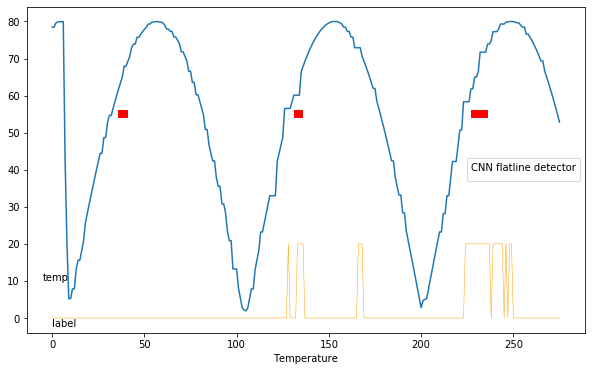

In [268]:

f, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(time_sauber, X[:,10]) #, cmap='coolwarm')
ax.text(-5,10, 'temp')
ax.set_xlabel('Temperature')
ax.legend(title='CNN flatline detector')
ax.plot(time_sauber, pred, lw=8, color='red')
ax.plot(time_sauber, yy*20, lw=0.5, color='orange')
ax.text(0,yy[5]*20 - 2.4, 'label')